In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
#plt.style.use("ABG_default")
import h5py
from abg_python.all_utils import nameAxes
from abg_python.distinct_colours import get_distinct
colors = get_distinct(5)
import pandas as pd
%load_ext autoreload
%autoreload 2

In [2]:
from wind.python.odecache import ODECache

In [17]:
my_cache = ODECache('FullChimes_neqntile.1_nsystemtile.1_fixed.1_abs.5e3_rel.5e3','cache.hdf5',solvers=['SIE','RK2','CHIMES'])

../data/FullChimes_neqntile.1_nsystemtile.1_fixed.1_abs.5e3_rel.5e3
(21, 40)
(21, 40)
(21, 40)
wrong nr of distinct colours!
No memory profiling information for ODECache FullChimes_neqntile.1_nsystemtile.1_fixed.1_abs.5e3_rel.5e3 - CHIMES - RK2 - SIE CHIMES
No memory profiling information for ODECache FullChimes_neqntile.1_nsystemtile.1_fixed.1_abs.5e3_rel.5e3 - CHIMES - RK2 - SIE RK2
No memory profiling information for ODECache FullChimes_neqntile.1_nsystemtile.1_fixed.1_abs.5e3_rel.5e3 - CHIMES - RK2 - SIE SIE


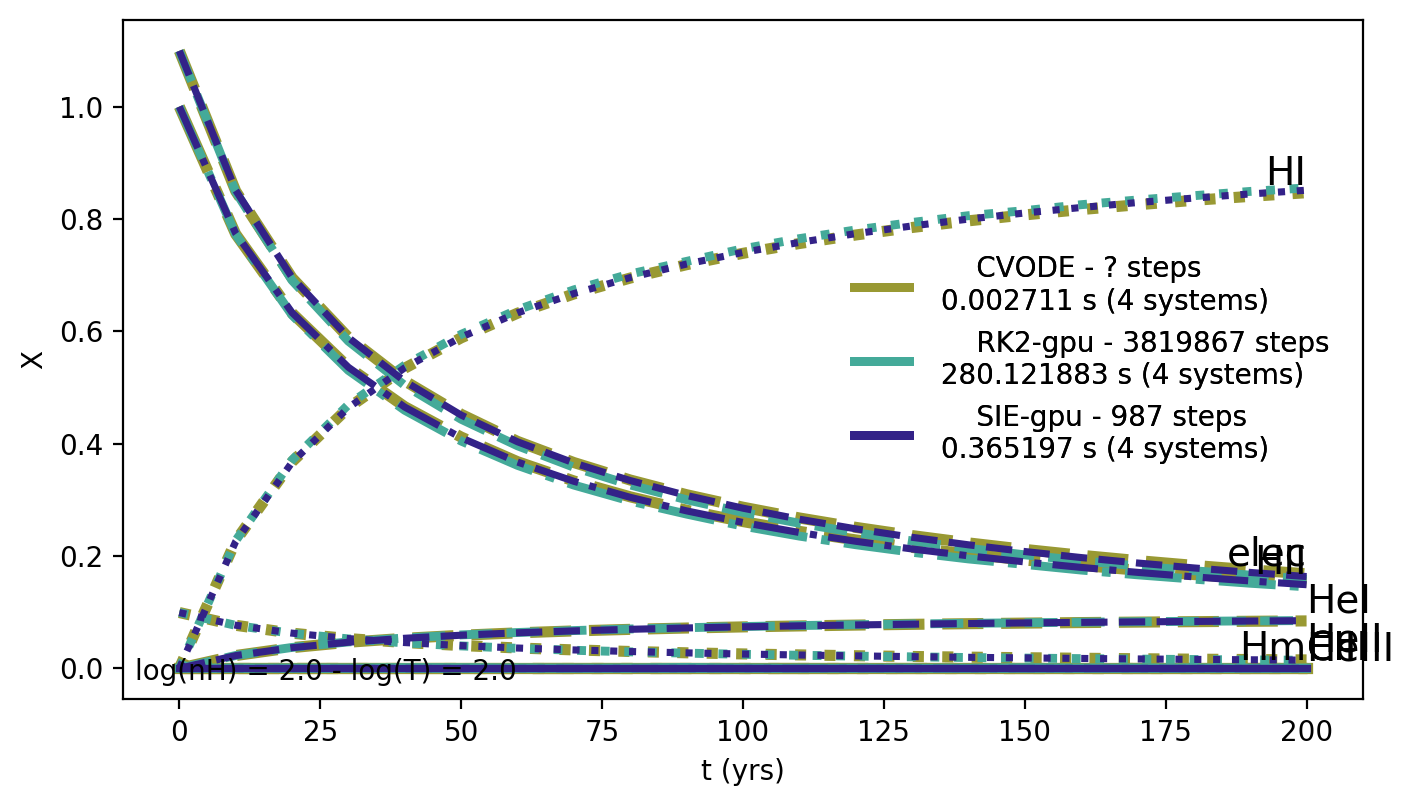

In [21]:
plt.clf()
my_cache.plot_system_over_time(0,ax=plt.gca(),xname='t (yrs)',yname='X',equation_indices=[1,2,4,5,6]) ## 3 is molecular, so are 7-9, 0 is ne
plt.gcf().set_facecolor('white')
plt.gcf().set_size_inches(8,4.5)
plt.gcf().set_dpi(200)

plt.gcf()

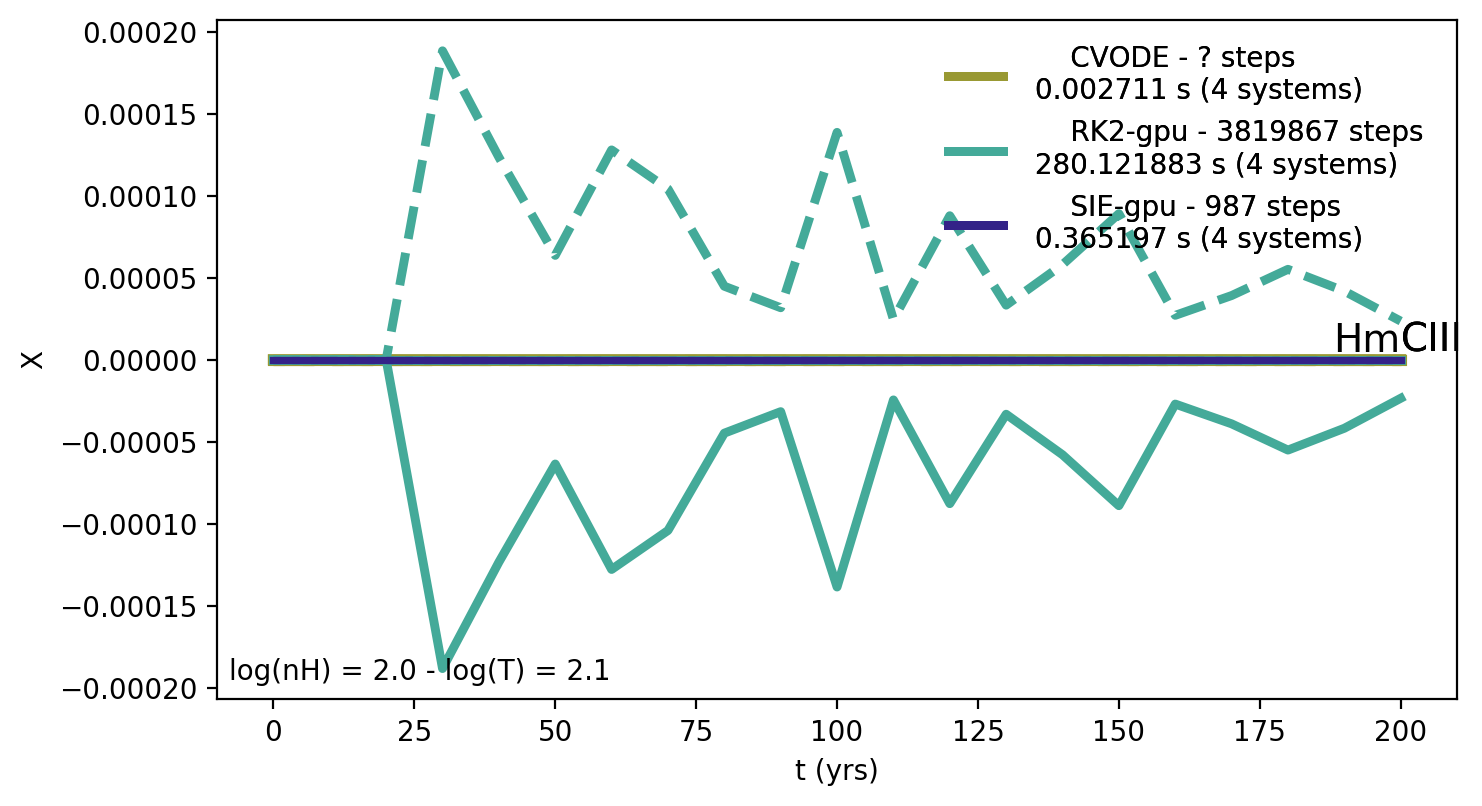

In [24]:
plt.clf()
my_cache.plot_system_over_time(2,ax=plt.gca(),xname='t (yrs)',yname='X',equation_indices=set(range(10))-set([0,1,2,4,5,6])) ## 3 is molecular, so are 7-9, 0 is ne
plt.gcf().set_facecolor('white')
plt.gcf().set_size_inches(8,4.5)
plt.gcf().set_dpi(200)

plt.gcf()

/Users/agurvich/anaconda/envs/ytdev/lib/python3.6/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


['SIE'] solvers used


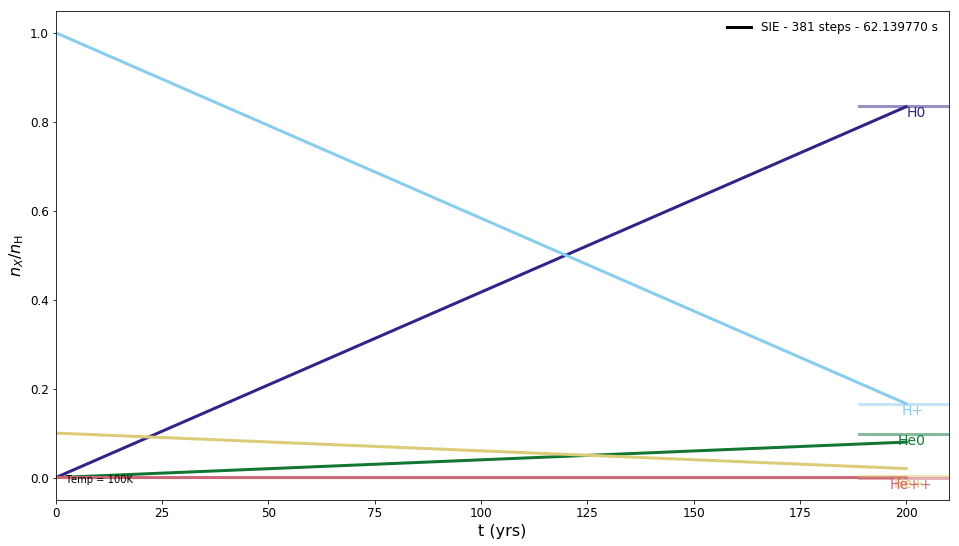

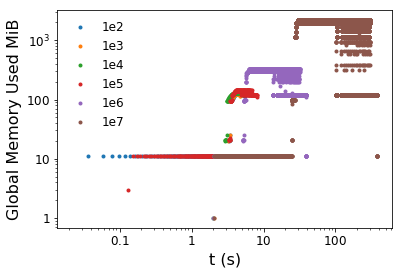

In [4]:
KatzSystem = ODECache("katz96_out.hdf5",['SIE'],eqm=True)
KatzSystem.plot_system_over_time(0,plot_eqm=True,
                                savefig='katz_SIE_2step.pdf')
plt.figure()
KatzSystem.plot_memory_usage_versus_size(['1e%d'%i for i in range(2,8)],
                                         savefig='katz_memory_usage_post_leak.pdf')

In [5]:
NRTest = ODECache("NR_test.hdf5")

['SIE'] solvers used


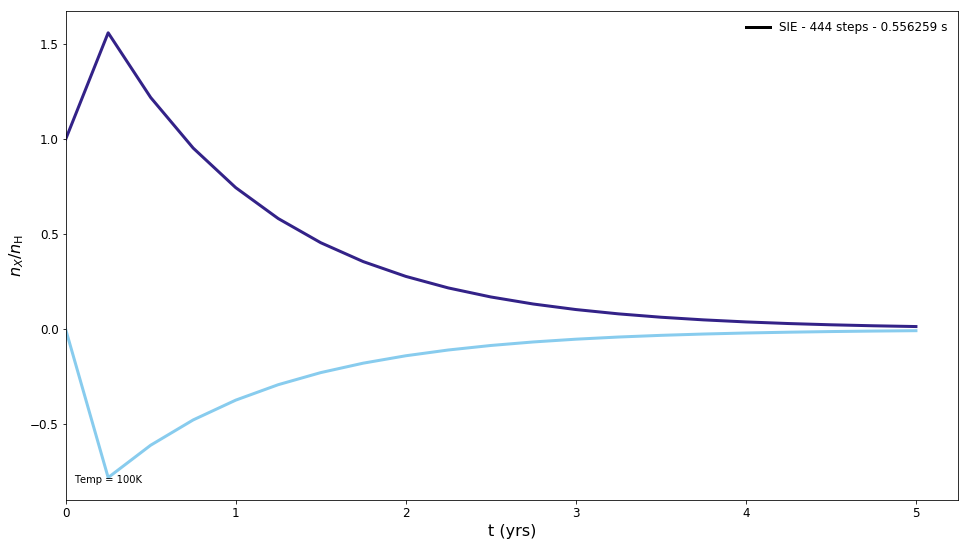

In [6]:
NRTest.plot_system_over_time(0)